https://github.com/martinarjovsky/WassersteinGAN

https://vincentherrmann.github.io/blog/wasserstein/

https://github.com/martinarjovsky/WassersteinGAN/issues/2

# To do:

* Data exploration (distribution of bootstrap against entire cube)
* Play around with optimizers
* NORMALIZE DATA
* Revise and change architecture (less convs)
* Visualization function
* Bigger cubes with no padding
* Use other standarizations of data
* Gradient penalty instead if weight clamping
* Locally connected layers
* Weight initialization
* Mini batch discrimination
* Save weights to continue training




In [1]:
from __future__ import print_function
#import argparse
import os
import random
import numpy as np

#import torch

import torch.multiprocessing as mp
mp.set_start_method('spawn')

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import matplotlib as mpl

ngpu = 1   

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_loss(datalist, ylabel, log_):
    plt.figure(figsize=(20,10))
    
    if ylabel=='Wasserstein loss':
        plt.plot([-x for x in datalist], linewidth=3.5, color='b')
        
    else:
        plt.plot([x for x in datalist], linewidth=3.5, color='b')
        
    plt.ylabel(ylabel, fontsize=16)
    plt.yticks(fontsize=14)
    plt.yticks(fontsize=14)
    if ylabel=='Generator loss':
        plt.xlabel('Epoch', fontsize=16)
    else:
        plt.xlabel('Iterations', fontsize=16)
    plt.show()
    


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()

In [3]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

def get_samples(datapath, s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-s_sample
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, sample_coords)
        
        sample_list.append(sample_coords)
    
    #print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    #datapath='../../../../../'
    #f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    #f=f['delta_HI']
    
    counter = 0
    for c in sample_list:
        #if counter%100==0:
        #    print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        #a = np.array(a)
        a = np.array(a)
        sample_array.append(a)
    
        counter = counter + 1
        
    
    return np.array(sample_array)

In [4]:
class HydrogenDataset(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, root_dir, s_test, s_sample, nsamples, redshift, transform):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        #print("The whole file size is " + str(int(file_size)) + " MBs")
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_sample = s_sample
        self.t_coords = define_test(self.s_test,self.s_sample)
        self.nsamples = nsamples
        self.redshift = redshift
        self.transform=transform
        if self.transform=='max':
            #self.max_cube=get_max_cube(self.root_dir, self.redshift)
            #print(self.max_cube)
            # For redshift 5: max5=4376932000
            self.max_cube=4376932000
       # if self.transform=='normalize':
        #    self.mean=

    def __len__(self):
        # Function called when len(self) is executed
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        sample = get_samples(datapath=self.root_dir,
                            s_sample = self.s_sample,
                             nsamples = 1,
                             redshift = self.redshift,
                             test_coords = self.t_coords)
        #sample=np.array(sample)
        if self.transform=='max':
            #print(sample.shape)
            sample = sample / self.max_cube
        if self.transform=='normalize':
            sample = (sample-mean_5)/std_5
        if self.transform=='log':
            sample= np.log(sample+1)
        #print(np.array(sample).shape)
    
        sample=sample.reshape((1,self.s_sample,self.s_sample,self.s_sample))

        return torch.tensor(sample)

In [5]:
#Old
class HydrogenDataset_old(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, root_dir, s_test, s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        #print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        #self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_sample = s_sample
        self.t_coords = define_test(self.s_test,self.s_sample)
        self.nsamples = nsamples
        self.redshift = redshift
        
        #self.samples = get_samples(s_sample = self.s_sample,
        #                     nsamples = self.nsamples,
       #                      redshift = self.redshift,
             #                test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed      
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,self.s_sample,self.s_sample,self.s_sample))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
        #sample = sample/1e6

        return sample

# Helper functions

In [6]:
#f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
#f=f['delta_HI']

def get_statistics(datapath, redshift):
    f_ = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f_['delta_HI']
    
    max_list, min_list, mean_list, variance_list= [], [], [], []
   
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
        #variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    #mean_cube = np.mean(mean_list)
    #for i in range(f.shape[0]):
    
    f.close()
    
    max_cube = max(max_list)
    min_cube = min(min_list)
    mean_cube = np.mean(mean_list)
    #stddev_cube = np.sqrt(np.mean(variance_list))
    return max_cube, min_cube, mean_cube   

def get_max_cube(datapath, redshift):
    f= h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
   
    return max_cube

def get_min_cube(datapath, redshift):
    min_list = [] 
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
    min_cube = min(min_list)
    return min_cube

def get_mean_cube(datapath, redshift):
    mean_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
    mean_cube = np.mean(mean_list)
    return mean_cube

def get_stddev_cube(datapath, redshift, mean_cube):
    variance_list = []
    for i in range(f.shape[0]):
        variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    stddev_cube = np.sqrt(np.mean(variance_list))
    return stddev_cube

In [7]:
#mean_5=get_mean_cube('../../../../../','5.0')
#std_5=get_stddev_cube('../../../../../','5.0',mean_5)
mean_5=14592.24
std_5=922711.56
max_5=4376932000

In [8]:
class Generator__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.ConvTranspose3d(in_channels=nz, 
                      out_channels=self.cube_len*8, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     #padding=(1,1,1), # == 1
                      padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len*8),
            nn.ReLU(True),
            
            #2
            nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*4),
            nn.ReLU(True),
            
            #3
            nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*2),
            nn.ReLU(True),
            
            #4
            nn.ConvTranspose3d(self.cube_len*2, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len),
            nn.ReLU(True),
            
            #5 
            nn.ConvTranspose3d(self.cube_len, 1, kernel_size=4, stride=2, bias=self.bias, padding=1)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z,
            nn.ConvTranspose3d(in_channels=nz,
                               out_channels=ngf * 16,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0,
                               bias=False),
            nn.BatchNorm3d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose3d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose3d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose3d(ngf, nc, 4, 2, 1, bias=False),
            #nn.Tanh(),
            nn.ReLU(True)
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('G: ' ,output.size())
        return output

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
class Discriminator__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.Conv3d(in_channels=1, 
                      out_channels=self.cube_len, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=1,
                     # padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #2
            nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*2),
            nn.LeakyReLU(self.leak_value, inplace=True),
  
            
            #3
            nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*4),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #4
            nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*8),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #5
            nn.Conv3d(self.cube_len*8, self.cube_len*16, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len* 16),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #6
            nn.Conv3d(self.cube_len*16, 1, kernel_size=4, stride=1, bias=self.bias, padding=0)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('D0:',output.size)
        output = output.mean(0)
        #print('D1:',output.size)
        #return output.view(-1, 1).squeeze(1)
        return output.view(1)

In [12]:
#https://github.com/rimchang/3DGAN-Pytorch/blob/master/3D_GAN/model.py
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nc = number of channels
            
            nn.Conv3d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=(1,1,1), # == 1
                     # padding=0,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv3d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv3d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
           # nn.Conv3d(ndf * 16, ndf*32, 4, 2, 1, bias=False),
            #nn.BatchNorm3d(ndf * 32),
            #nn.LeakyReLU(0.2, inplace=True),
            
            #Final conv (D does not have ti output a probability)
            nn.Conv3d(ndf*16, 1, 4, 1, 0, bias=False)
        )
        #self.main = main

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
            
        #print('D0:',output.size())
        output = output.mean(0)
        #return output.view(-1, 1).squeeze(1)
        #print('D1:',output.size())
        return output.view(1)

# MLP

In [13]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize *isize),
            #nn.ReLU(True)
            nn.Tanh()
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize, self.isize)

In [14]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize *isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3) *input.size(4))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [15]:
#Run MlP

redshift='5.0'
n_samples =300
s_sample =32

s=64
ngf = 512 # dimension of the cube
ndf = ngf      # dimension of the cube
batchSize = 16

cuda=True
workers = 0

# imageSize = 128
nz = 200       # 'size of the latent z vector'

niter = 100      # 'number of epochs to train for'
cuda = True
   
netG_arg = ""        # "path to netG (to continue training)"
netD_arg = ""        # "path to netD (to continue training)"
outf = "."       # 'folder to output images and model checkpoints'
manualSeed = 1   # 'manual seed'

#.0002
lrD = 0.002   
lrG = 0.002
Diters=300

clamp_lower=-.001
clamp_upper=.001

#n_samples = 100 # number of subcubes to sample
experiment='first_iteration/'

real_label = 1
fake_label = -1

device = torch.device("cuda:0" if cuda else "cpu")

# number of channels
nc = 1

datapath='../../../../../'
f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']
    
dataset = HydrogenDataset(root_dir = '../../../../../',
                                    s_test = 1024, 
                                    s_sample = s_sample, 
                                    nsamples = n_samples, 
                                    redshift = "5.0",
                                  transform='normalize')

#dataset = sampled_subcubes
#sampled_subcubes=0
workers=0
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers) )


#self, isize, nz, nc, ndf, ngpu
#netG = Generator(ngpu, s, .2, False).to(device)
netG = MLP_G(s_sample, nz, 1, ngf, ngpu).to(device)
netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
if netG_arg != '':
    netG.load_state_dict(torch.load(netG_param))
print(netG)

#netD = Discriminator(ngpu, s, .2, False).to(device)
netD = MLP_D(s_sample, nz, 1, ndf, ngpu).to(device)
netD.apply(weights_init)
if netD_arg != '':
    netD.load_state_dict(torch.load(netD_arg))
print(netD)


MLP_G(
  (main): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=512, out_features=32768, bias=True)
    (7): Tanh()
  )
)
MLP_D(
  (main): Sequential(
    (0): Linear(in_features=32768, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [17]:
# setup optimizer
optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

wass_loss=[]
errG_l=[]
errD_real_l=[]
errD_fake_l=[]

input = torch.FloatTensor(batchSize, 1, s_sample, s_sample, s_sample)
noise = torch.FloatTensor(batchSize, nz,1,1,1, device=device).normal_(0,0.33)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1,1).normal_(0, 0.33)
#fixed_noise = torch.FloatTensor(1, nz, 1, 1,1).normal_(0, 1)

one = torch.FloatTensor([1])
#one = torch.tensor(1, dtype=torch.float)
mone = one * -1

#torch.cuda.empty_cache()
if cuda==True:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()


gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
            
        j=0
        while j < Diters and i < len(dataloader):
            j += 1
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            data=data_iter.next()
            #print(data.shape)
            i+=1
            
            real_cpu= data
            netD.zero_grad()
          
            batch_size=real_cpu.size(0)
            if cuda==True:
                real_cpu=real_cpu.cuda()
        
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
                
            errD_real=netD(inputv)
            
            #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
            #ones=[torch.ones(1).cuda(gpu) for _ in range(len(errD_real))]
            #print('errD_real: ', errD_real)
            errD_real.backward(one)
                
            #Train with fake
            noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            #with torch.no_grad():
                #noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
            #print(fake.shape)
            inputv=fake
               
            errD_fake = netD(inputv)
            #print(errD_fake.shape)
            #label.fill_(fake_label)
            #print('errD_fake: ' ,errD_fake)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            
            wass_loss.append(float(errD.data[0]))
            errD_real_l.append(float(errD_real.data[0]))
            errD_fake_l.append(float(errD_fake.data[0]))
            
            optimizerD.step()
            
        ############################
        # (2) Update G network
        ###########################
        #print('Updating G')
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
        noisev = Variable(noise)
        fake = netG(noisev)
        #print('G:',fake.shape)
        errG = netD(fake)
        
        #print('errG: ', errG)
        #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        
        #wass_loss.append(float(errD.data[0]))
        errG_l.append(float(errG.data[0]))
        #errD_real_l.append(float(errD_real.data[0]))
        #errD_fake_l.append(float(errD_fake.data[0]))
        
        #print(gen_iterations)
        #if (gen_iterations % 500 == 0 and gen_iterations>200) or float(errD.data[0])<=min(wass_loss
        #print(gen_iterations)
        if gen_iterations % 2 == 0:
            fake = netG(Variable(fixed_noise, volatile=True))
            #print(fake.shape)
            m=random.randint(0, batch_size-1)
            print('Fake:')
            visualize_cube(cube=np.array(fake[m].view(s_sample,s_sample,s_sample).detach()),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            print('Real:')
            visualize_cube(cube=np.array(data[m].view(s_sample,s_sample,s_sample)),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
                
                
            fake_s=fake[m]
            fake_s=np.array(fake_s.detach())
            print(fake_s.size)
            print('Mass fake:', int(fake_s.sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(fake_s.flatten()))/ len(np.array(fake_s.flatten())),3))
            
            print('Mass real:', int(data[m].sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(data[m].flatten()))/ len(np.array(data[m].flatten())),3))
            print('---------------------------------------------------------')
            fake_s=0
        #    real_cpu = real_cpu.mul(0.5).add(0.5)
         #   vutils.save_image(real_cpu, '{0}/real_samples.png'.format(opt.experiment))
            
           # fake.data = fake.data.mul(0.5).add(0.5)
            #vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment, gen_iterations))

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment, epoch))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


KeyboardInterrupt: 

In [ ]:
stop

# DCGAN

In [13]:
#Run DCGAN
redshift='5.0'
n_samples =600
s_sample = 128

s=8
ngf = 8 # dimension of the cube
ndf = ngf      # dimension of the cube
batchSize = 16

cuda=True
workers = 0

# imageSize = 128
nz = 100       # 'size of the latent z vector'

niter = 100      # 'number of epochs to train for'
cuda = True
   
netG_arg = ""        # "path to netG (to continue training)"
netD_arg = ""        # "path to netD (to continue training)"
outf = "."       # 'folder to output images and model checkpoints'
manualSeed = 1   # 'manual seed'

#.0002
lrD = 0.002   
lrG = 0.002
Diters=300

clamp_lower=-.001
clamp_upper=.001

#n_samples = 100 # number of subcubes to sample
experiment='first_iteration/'

real_label = 1
fake_label = -1

device = torch.device("cuda:0" if cuda else "cpu")

# number of channels
nc = 1

datapath='../../../../../'
f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']
    
dataset = HydrogenDataset(root_dir = '../../../../../',
                                    s_test = 1024, 
                                    s_sample = s_sample, 
                                    nsamples = n_samples, 
                                    redshift = "5.0",
                                  transform='normalize')

#dataset = sampled_subcubes
#sampled_subcubes=0
workers=0
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers) )

In [14]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1


In [15]:
#netG = Generator(ngpu, s, .2, False).to(device)
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
if netG_arg != '':
    netG.load_state_dict(torch.load(netG_param))
print(netG)

#netD = Discriminator(ngpu, s, .2, False).to(device)
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if netD_arg != '':
    netD.load_state_dict(torch.load(netD_arg))
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose3d(100, 128, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose3d(16, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (13

In [16]:
# setup optimizer
optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

In [17]:
optimizerD  = optim.Adam(netD.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-3, betas=(0.9, 0.999))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[0/100][38/38][1] Loss_D: -0.000000 Loss_G: -0.000040 Loss_D_real: -0.000039 Loss_D_fake -0.000039
Fake:


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Real:


2097152
Mass fake: 103311 // Non-Zero %:  0.546
Mass real: -11248 // Non-Zero %:  1.0
---------------------------------------------------------
[1/100][38/38][2] Loss_D: -0.000000 Loss_G: -0.000039 Loss_D_real: -0.000039 Loss_D_fake -0.000039
Fake:


Real:


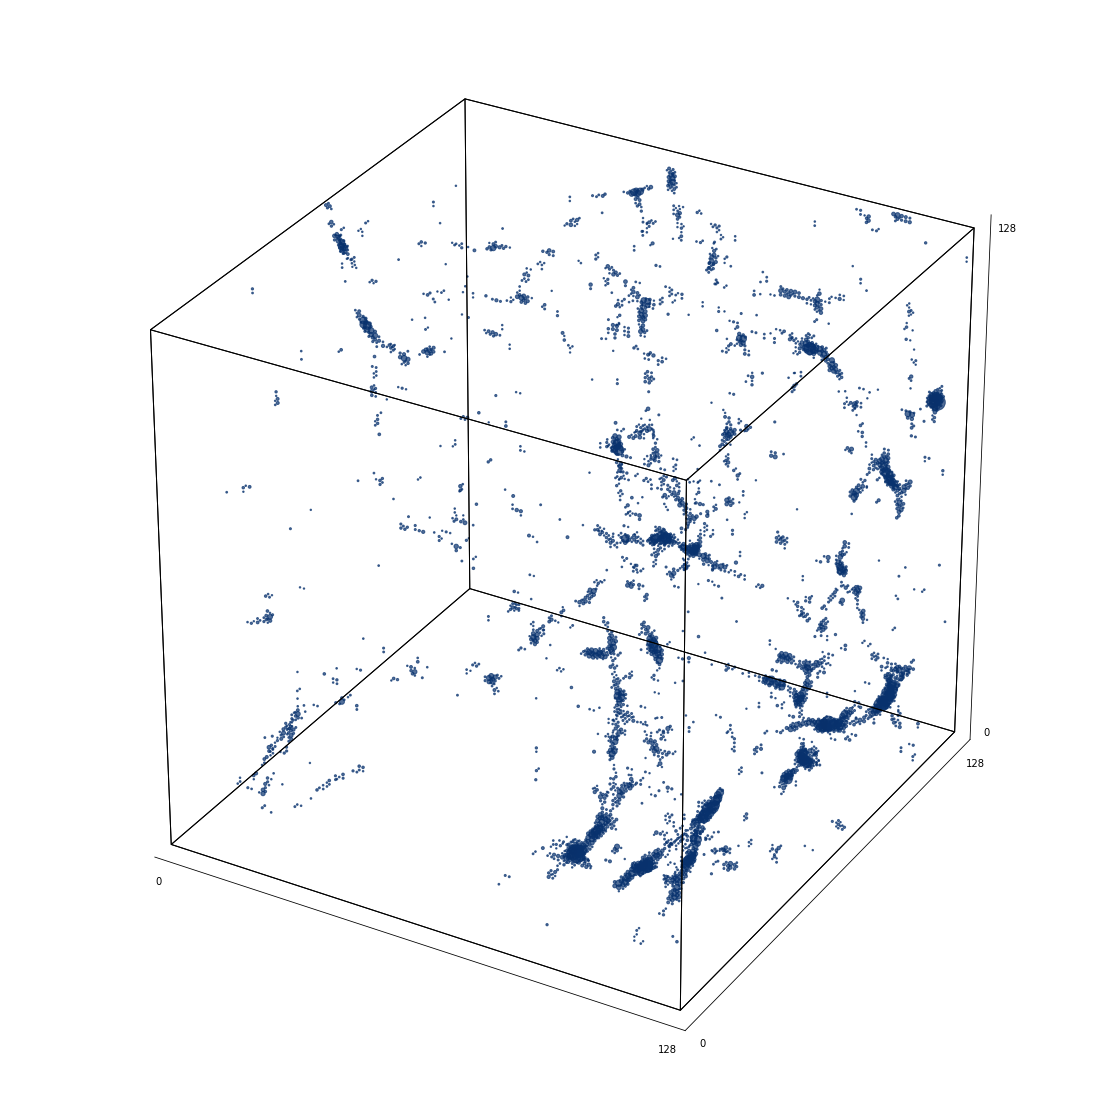

2097152
Mass fake: 96247 // Non-Zero %:  0.548
Mass real: 65029 // Non-Zero %:  1.0
---------------------------------------------------------
[2/100][38/38][3] Loss_D: -0.000000 Loss_G: -0.000040 Loss_D_real: -0.000039 Loss_D_fake -0.000039
Fake:


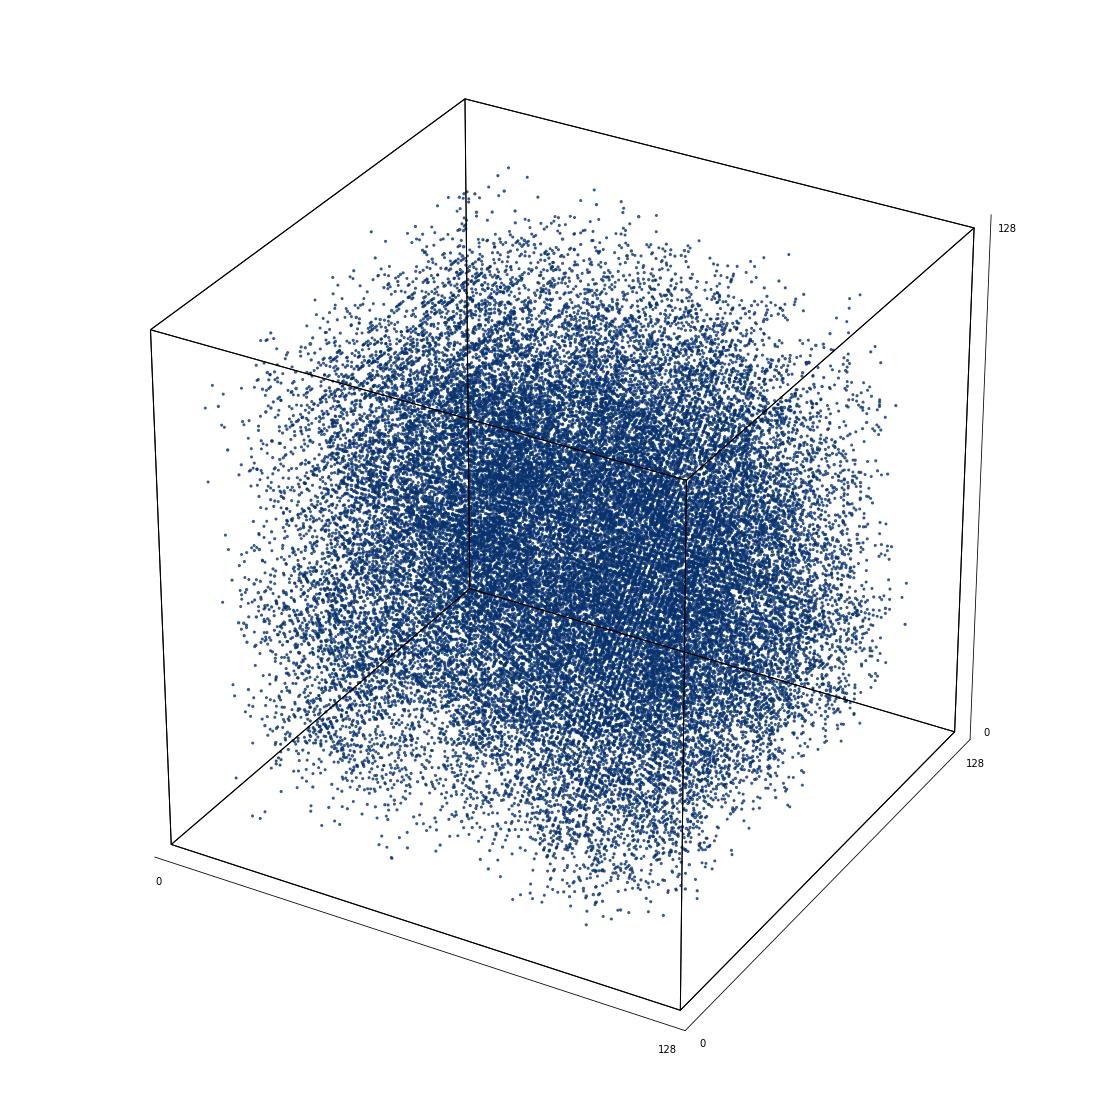

Real:


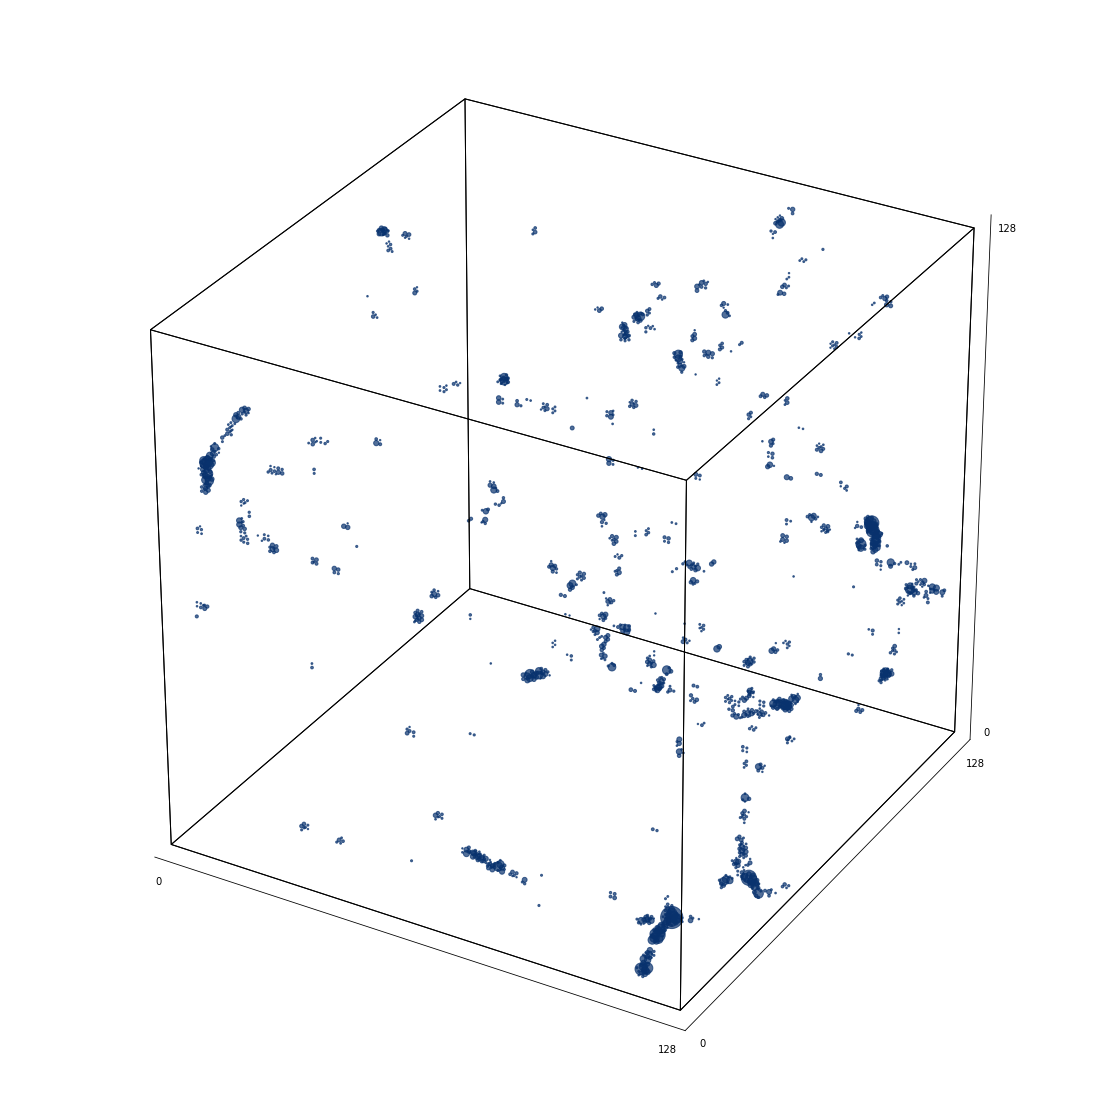

2097152
Mass fake: 98548 // Non-Zero %:  0.547
Mass real: -26728 // Non-Zero %:  1.0
---------------------------------------------------------
[3/100][38/38][4] Loss_D: 0.000000 Loss_G: -0.000040 Loss_D_real: -0.000040 Loss_D_fake -0.000040
Fake:


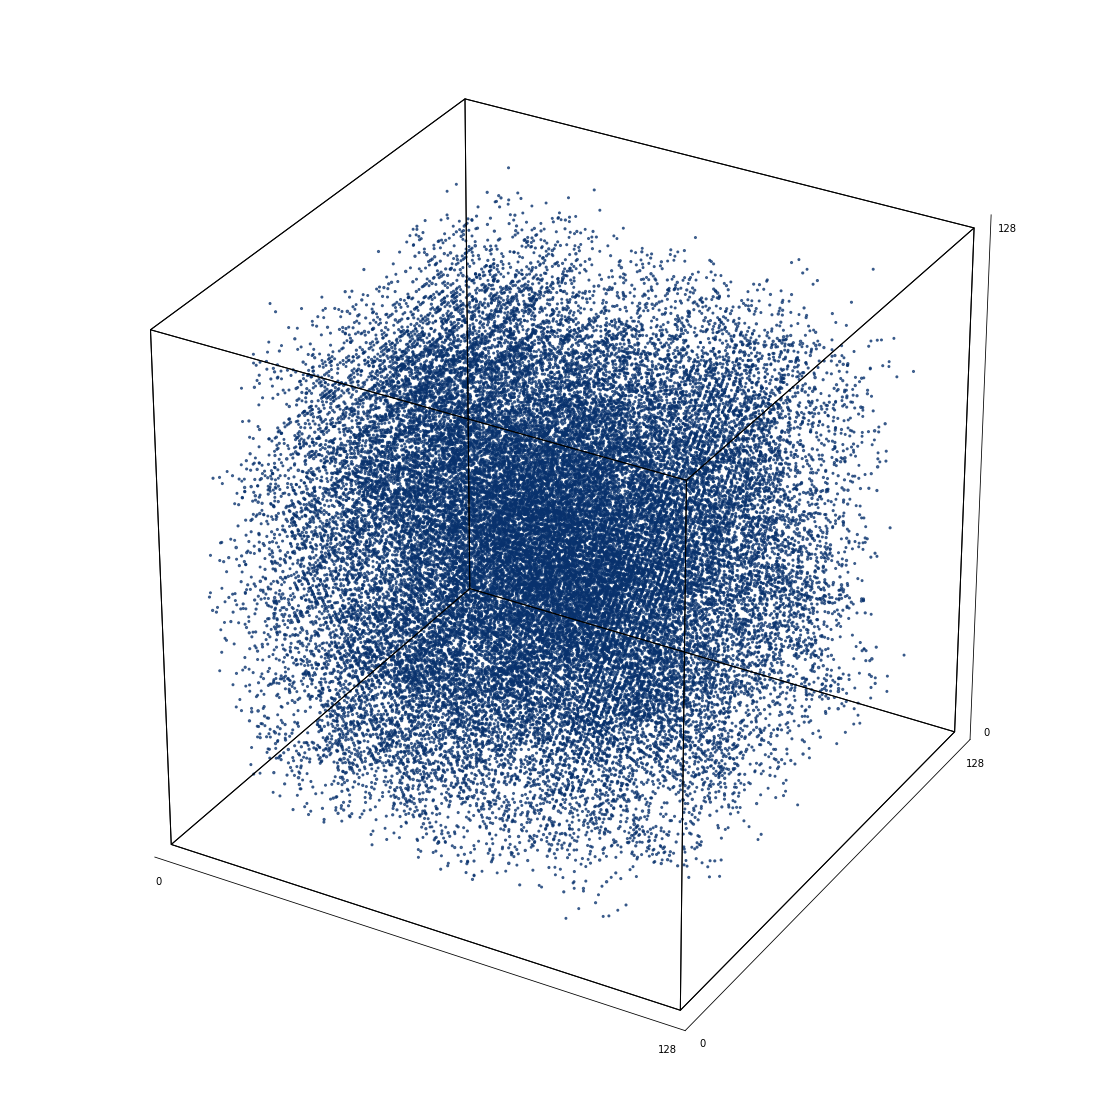

Real:


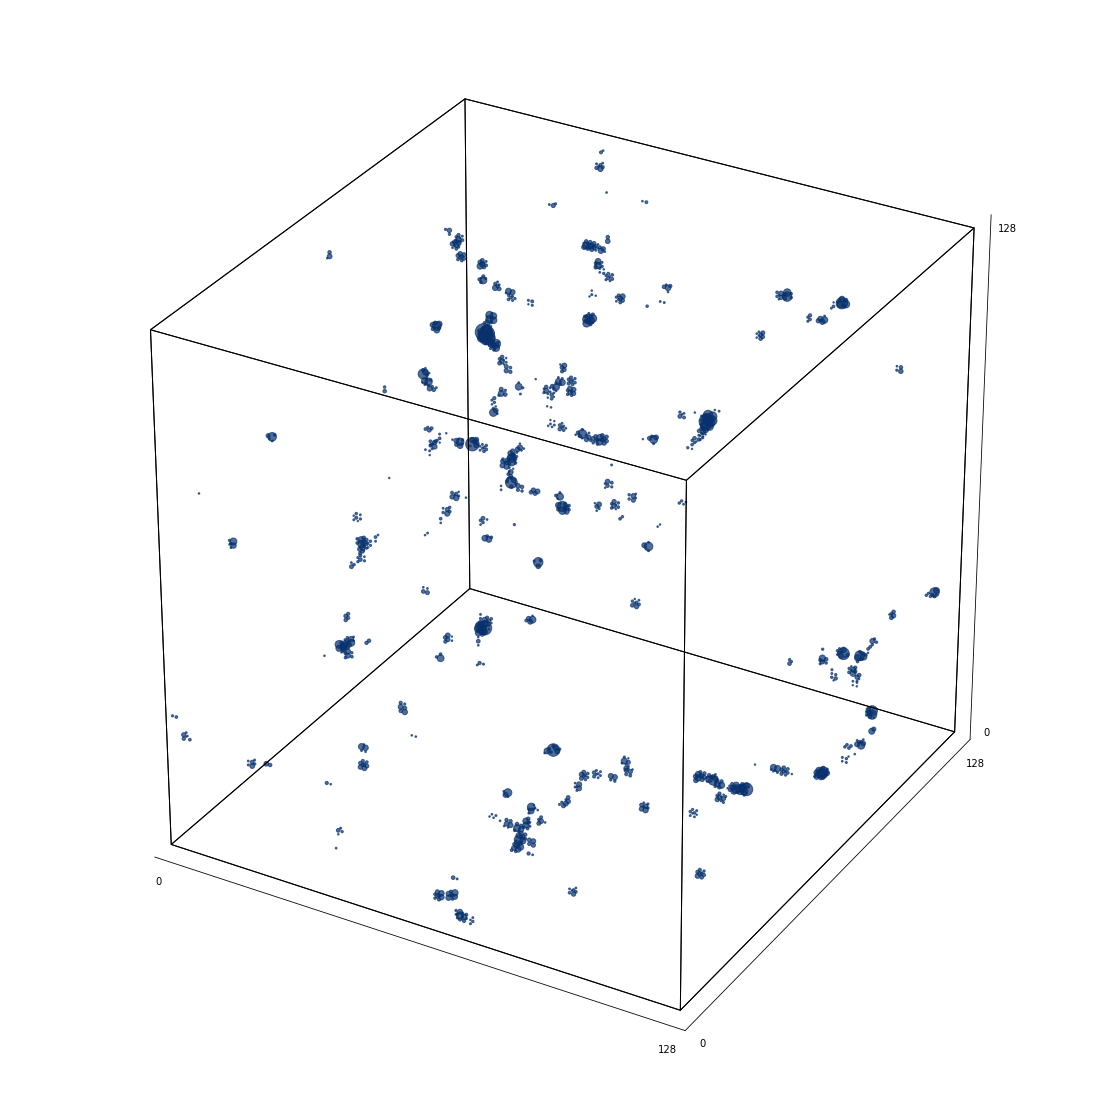

2097152
Mass fake: 96690 // Non-Zero %:  0.548
Mass real: -29793 // Non-Zero %:  1.0
---------------------------------------------------------


KeyboardInterrupt: 

In [18]:
#Training loop
wass_loss=[]
errG_l=[]
errD_real_l=[]
errD_fake_l=[]

input = torch.FloatTensor(batchSize, 1, s_sample, s_sample, s_sample)
noise = torch.FloatTensor(batchSize, nz,1,1,1, device=device).normal_(0,0.33)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1,1).normal_(0, 0.33)
#fixed_noise = torch.FloatTensor(1, nz, 1, 1,1).normal_(0, 1)

one = torch.FloatTensor([1])
#one = torch.tensor(1, dtype=torch.float)
mone = one * -1

#torch.cuda.empty_cache()
if cuda==True:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()


gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
            
        j=0
        while j < Diters and i < len(dataloader):
            j += 1
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            data=data_iter.next()
            #print(data.shape)
            i+=1
            
            real_cpu= data
            netD.zero_grad()
          
            batch_size=real_cpu.size(0)
            if cuda==True:
                real_cpu=real_cpu.cuda()
        
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
                
            errD_real=netD(inputv)
            
            #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
            #ones=[torch.ones(1).cuda(gpu) for _ in range(len(errD_real))]
            #print('errD_real: ', errD_real)
            errD_real.backward(one)
                
            #Train with fake
            noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
            noisev = Variable(noise, volatile = True) # totally freeze netG
           # with torch.no_grad():
            #    noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
            #print(fake.shape)
            inputv=fake
               
            errD_fake = netD(inputv)
            #print(errD_fake.shape)
            #label.fill_(fake_label)
            #print('errD_fake: ' ,errD_fake)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            
            wass_loss.append(float(errD.data[0]))
            errD_real_l.append(float(errD_real.data[0]))
            errD_fake_l.append(float(errD_fake.data[0]))
            
            optimizerD.step()
            
        ############################
        # (2) Update G network
        ###########################
        #print('Updating G')
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1, 1).normal_(0, 0.33)
        noisev = Variable(noise)
        fake = netG(noisev)
        #print('G:',fake.shape)
        errG = netD(fake)
        
        #print('errG: ', errG)
        #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        
        #wass_loss.append(float(errD.data[0]))
        errG_l.append(float(errG.data[0]))
        #errD_real_l.append(float(errD_real.data[0]))
        #errD_fake_l.append(float(errD_fake.data[0]))
        
        #print(gen_iterations)
        #if (gen_iterations % 500 == 0 and gen_iterations>200) or float(errD.data[0])<=min(wass_loss
        #print(gen_iterations)
        if gen_iterations % 1 == 0:
            fake = netG(Variable(fixed_noise, volatile=True))
            #print(fake.shape)
            m=random.randint(0, batch_size-1)
            print('Fake:')
            visualize_cube(cube=np.array(fake[m].view(s_sample,s_sample,s_sample).detach()),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            print('Real:')
            visualize_cube(cube=np.array(data[m].view(s_sample,s_sample,s_sample)),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
                
                
            fake_s=fake[m]
            fake_s=np.array(fake_s.detach())
            print(fake_s.size)
            print('Mass fake:', int(fake_s.sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(fake_s.flatten()))/ len(np.array(fake_s.flatten())),3))
            
            print('Mass real:', int(data[m].sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(data[m].flatten()))/ len(np.array(data[m].flatten())),3))
            print('---------------------------------------------------------')
            fake_s=0
        #    real_cpu = real_cpu.mul(0.5).add(0.5)
         #   vutils.save_image(real_cpu, '{0}/real_samples.png'.format(opt.experiment))
            
           # fake.data = fake.data.mul(0.5).add(0.5)
            #vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment, gen_iterations))

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment, epoch))

In [ ]:
fake_s

In [ ]:
plot_loss(wass_loss,'Wasserstein loss', log_=False)
plot_loss(errG_l,'Generator loss', log_=False)
plot_loss(errD_real_l,'D real loss', log_=False)

In [ ]:
def plot_mass_hist(fake, real):
    num_bins=100
    plt.figure(figsize=(20,10))
    plt.hist(fake.flatten(),alpha=0.5,bins=num_bins, label='Generated',normed=True,color='r')
    plt.hist(real.flatten(),alpha=0.5, bins=num_bins, label='Real',normed=True,color='g')
    plt.legend(loc='best',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.savefig('speed_hist.jpg',format='jpg', dpi=100)
    plt.show()

In [ ]:
a=np.array(fake[0].view(s_sample,s_sample,s_sample).detach())
a=a.flatten()
plt.hist(a)

In [ ]:
plot_mass_hist(np.array(fake[0].view(s_sample,s_sample,s_sample).detach()), np.array(data[0].view(s_sample,s_sample,s_sample).detach()))

In [ ]:
#s_sample=128
visualize_cube(cube=np.array(fake[1].view(s_sample,s_sample,s_sample).detach()),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)

#cube_mass_histogram(cube=np.array(fake[1].view(s_sample,s_sample,s_sample).detach()),   
 #            edge_dim=s_sample,       
  #           start_cube_index_x=0,
   #         start_cube_index_z=0,
    #         fig_size=(20,10),
     #        stdev_to_white=-3,
      #       norm_multiply=1,
       #      color_map="Blues",
        #     lognormal=False,
         #    hist_color="b",
          #  hist_bins=300)


visualize_cube(cube=np.array(fake[1].view(s_sample,s_sample,s_sample).detach()),
                               edge_dim = s_sample,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)

In [ ]:
visualize_cube(cube=np.array(data[0].view(128,128,128).detach()),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)

visualize_cube(cube=np.array(data[1].view(128,128,128).detach()),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = -3,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)